## **Predicting diamond prices - random forest regression**

**Table of contents**    
  - Libraries    
  - Loading and cleaning data set    
    - Description of numerical variables    
    - Changing data types    
    - Presenting various transformations regarding the dependent variable    
    - Relationship between the dependent variable and other numerical variables    
    - Relationship between the price variable and categorical columns    
  - Modeling part    
    - Data split    
    - Random Forest model with and without transformations    
    - Density plot of actual and predicted values    
    - Model stability    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=false
	flat=false
	minLevel=1
	maxLevel=3
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## Libraries

In [214]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error,mean_absolute_percentage_error
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import TransformedTargetRegressor

## Loading and cleaning data set

In [107]:
df = sns.load_dataset('diamonds')

### Description of numerical variables

In [108]:
df.describe().apply(lambda x: round(x,2)).iloc[1:,:]

,carat,depth,table,price,x,y,z
mean,0.80,61.75,57.46,3932.80,5.73,5.73,3.54
std,0.47,1.43,2.23,3989.44,1.12,1.14,0.71
min,0.20,43.00,43.00,326.00,0.00,0.00,0.00
25%,0.40,61.00,56.00,950.00,4.71,4.72,2.91
50%,0.70,61.80,57.00,2401.00,5.70,5.71,3.53
75%,1.04,62.50,59.00,5324.25,6.54,6.54,4.04
max,5.01,79.00,95.00,18823.00,10.74,58.90,31.80


### Changing data types

In [109]:
for col in ["cut","color","clarity"]:
    df[col] = df[col].astype("object")

### Presenting various transformations regarding the dependent variable

In [111]:
fitted_data, fitted_lambda = stats.boxcox(df['price'])

In [112]:
stats.boxcox(df['price'])[0]

array([4.79712774, 4.79712774, 4.79920606, ..., 6.14717712, 6.14717712,
       6.14717712])

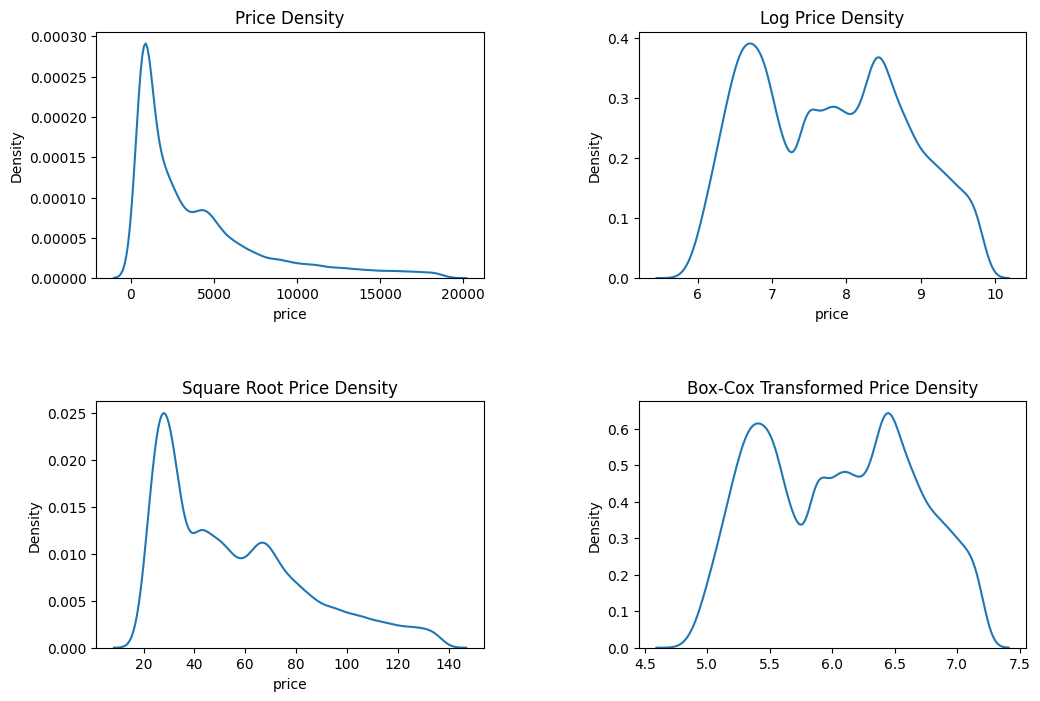

<Figure size 600x400 with 0 Axes>

In [113]:
fig, axes = plt.subplots(ncols = 2, nrows = 2, figsize = (12,8))
axes = axes.flatten()
fig.subplots_adjust(wspace=0.4, hspace=0.5)


plt.figure(figsize=(6,4))
sns.kdeplot(data=df['price'],ax=axes[0])
axes[0].set_title("Price Density")

sns.kdeplot(data=np.log(df['price']),ax=axes[1])
axes[1].set_title("Log Price Density")

sns.kdeplot(data=np.sqrt(df['price']),ax=axes[2])
axes[2].set_title("Square Root Price Density")

sns.kdeplot(data=stats.boxcox(df['price'])[0], ax = axes[3])
axes[3].set_title("Box-Cox Transformed Price Density")

plt.show()

In [114]:
numeric_list = df.select_dtypes(np.number).columns.to_list()

In [115]:
numeric_list.remove("price")

In [116]:
for ind, col in enumerate(numeric_list):
    print(ind,col)

0 carat
1 depth
2 table
3 x
4 y
5 z


### Relationship between the dependent variable and other numerical variables

#### A lot of variables are very slightly correlated with the Price variable, so it was decided to not include them in the model

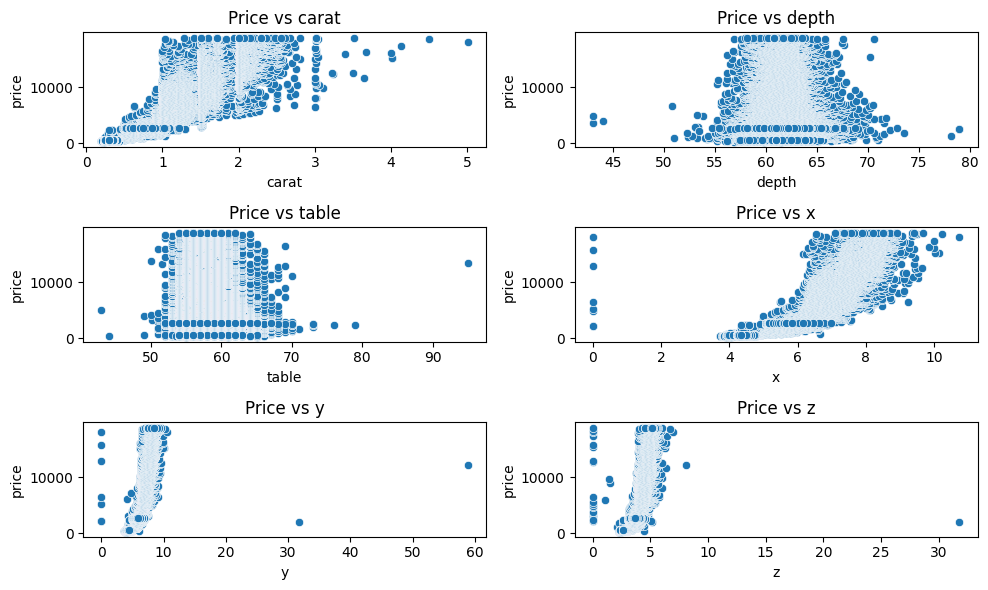

In [117]:
fig, axes = plt.subplots(ncols = 2, nrows = 3, figsize = (10,6))
axes = axes.flatten()
fig.subplots_adjust(wspace=0.4,hspace=0.5)

for ind, col in enumerate(numeric_list):
    sns.scatterplot(data=df, x = col, y = 'price', ax = axes[ind])
    axes[ind].set_title(f"Price vs {col}")

plt.tight_layout()
plt.show()

In [118]:
df.select_dtypes(np.number).corr().round(2)

,carat,depth,table,price,x,y,z
carat,1.00,0.03,0.18,0.92,0.98,0.95,0.95
depth,0.03,1.00,-0.30,-0.01,-0.03,-0.03,0.09
table,0.18,-0.30,1.00,0.13,0.20,0.18,0.15
price,0.92,-0.01,0.13,1.00,0.88,0.87,0.86
x,0.98,-0.03,0.20,0.88,1.00,0.97,0.97
y,0.95,-0.03,0.18,0.87,0.97,1.00,0.95
z,0.95,0.09,0.15,0.86,0.97,0.95,1.00


In [119]:
df.loc[:,df.columns.isin(["carat","price"])].corr().round(2)

,carat,price
carat,1.00,0.92
price,0.92,1.00


### Relationship between the price variable and categorical columns

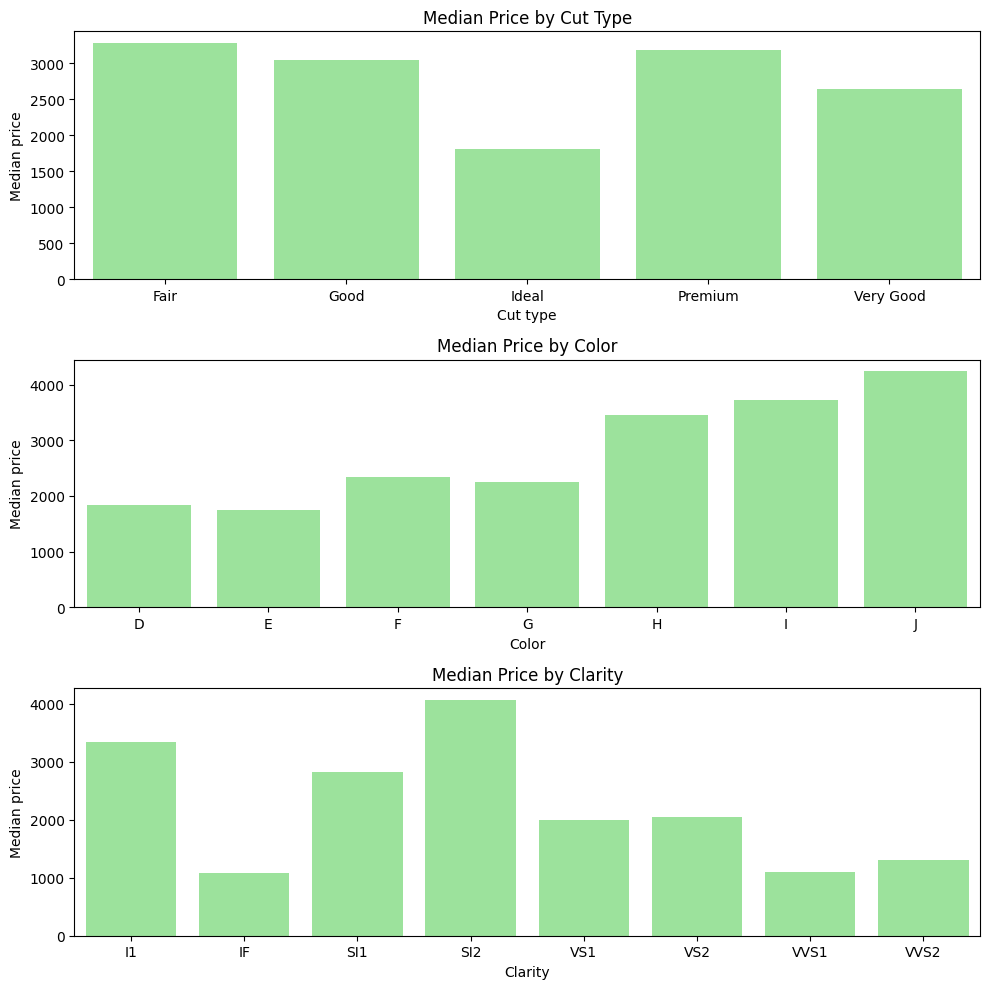

In [120]:
fig, axes = plt.subplots(ncols = 1, nrows= 3, figsize = (10,10))
axes = axes.flatten()
fig.subplots_adjust(hspace=0.4, wspace=0.5)

sns.barplot(data=df.groupby(["cut"])["price"].median().reset_index(name="median_price"),
            x="cut",
            y="median_price",
            color="lightgreen",
            ax = axes[0])
axes[0].set_title("Median Price by Cut Type")
axes[0].set_ylabel("Median price")
axes[0].set_xlabel("Cut type")

sns.barplot(data=df.groupby(["color"])["price"].median().reset_index(name="median_price"),
            x="color",
            y="median_price",
            color="lightgreen",
            ax = axes[1])
axes[1].set_title("Median Price by Color")
axes[1].set_ylabel("Median price")
axes[1].set_xlabel("Color")

sns.barplot(data=df.groupby(["clarity"])["price"].median().reset_index(name="median_price"),
            x="clarity",
            y="median_price",
            color="lightgreen",
            ax = axes[2])
axes[2].set_title("Median Price by Clarity")
axes[2].set_ylabel("Median price")
axes[2].set_xlabel("Clarity")


plt.tight_layout()
plt.show()

## Modeling part

### Data split

In [148]:
X = df.drop(["price","x","y","z","table","depth"],axis=1)
y = df['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.7, random_state=123)
print(f'X_train: {X_train.shape}')
print(f'X_test: {X_test.shape}')
print(f'y_train: {y_train.shape}')
print(f'y_test: {y_test.shape}')

X_train: (37758, 4)
X_test: (16182, 4)
y_train: (37758,)
y_test: (16182,)


In [149]:
X_train = pd.get_dummies(data=X_train, columns = ["cut","color","clarity"], dtype = "int",drop_first=True)
X_test = pd.get_dummies(data=X_test, columns = ["cut","color","clarity"], dtype = "int",drop_first=True)

In [150]:
X_test.head()

,carat,cut_Good,cut_Ideal,cut_Premium,cut_Very Good,color_E,color_F,color_G,color_H,color_I,color_J,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2
32685,0.31,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0
36258,0.46,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0
14429,1.21,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0
36250,0.41,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
460,0.90,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0


In [188]:
X_train.shape

(37758, 18)

### Random Forest model with and without transformations

#### The results are almost the same, whether the dependent variable was transformed or not, so it was decided to use the first model (where the Price variable was not transformed) for prediction purposes

In [247]:
rf_mod = RandomForestRegressor(n_estimators=250,max_depth = 16,max_features=12,random_state=123)
rf_mod.fit(X_train,y_train)

RandomForestRegressor(max_depth=16, max_features=12, n_estimators=250,
                      random_state=123)

In [248]:
print(f"Random Forest MAE: {round(mean_absolute_error(y_true = y_test, y_pred = rf_mod.predict(X_test)),4)}")
print(f"Random Forest MAPE: {round(mean_absolute_percentage_error(y_true = y_test, y_pred = rf_mod.predict(X_test)),4)}")

Random Forest MAE: 302.3129
Random Forest MAPE: 0.0842


In [217]:
rf_transf_log = TransformedTargetRegressor(regressor=RandomForestRegressor(n_estimators=250,max_depth = 16,max_features=12,random_state=123),
                                            func = np.log,
                                            inverse_func=np.exp)

rf_transf_log.fit(X_train, y_train)
rf_transf_log_pred = rf_transf_log.predict(X_test)

In [218]:
print(f"Random Forest MAE (transfomed target): {round(mean_absolute_error(y_true = y_test, y_pred = rf_transf_log_pred),4)}")
print(f"Random Forest MAPE (transformed target): {round(mean_absolute_percentage_error(y_true = y_test, y_pred = rf_transf_log_pred),4)}")

Random Forest MAE (transfomed target): 304.3345
Random Forest MAPE (transformed target): 0.0825


In [219]:
rf_transf_sqrt = TransformedTargetRegressor(regressor=RandomForestRegressor(n_estimators=250,max_depth = 16,max_features=12,random_state=123),
                                            func = np.sqrt,
                                            inverse_func=np.square)

rf_transf_sqrt.fit(X_train, y_train)
rf_transf_sqrt_pred = rf_transf_sqrt.predict(X_test)

In [223]:
print(f"Random Forest MAE (transfomed target): {round(mean_absolute_error(y_true = y_test, y_pred = rf_transf_sqrt_pred),4)}")
print(f"Random Forest MAPE (transformed target): {round(mean_absolute_percentage_error(y_true = y_test, y_pred = rf_transf_sqrt_pred),4)}")

Random Forest MAE (transfomed target): 304.0523
Random Forest MAPE (transformed target): 0.0833


### Density plot of actual and predicted values

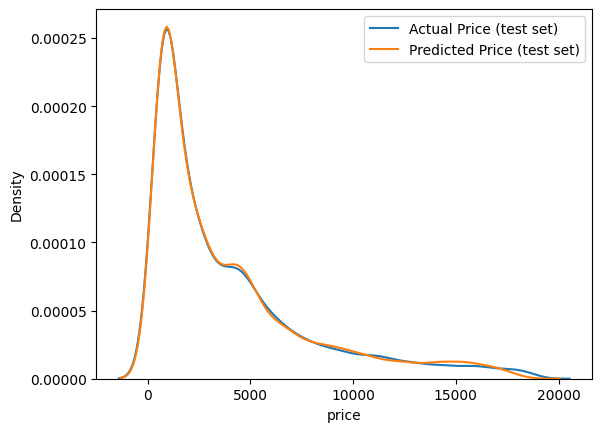

In [230]:
sns.kdeplot(data=y_test,label="Actual Price (test set)")
sns.kdeplot(data=rf_mod.predict(X_test),label="Predicted Price (test set)")
plt.legend()
plt.show()

### Model stability

#### There seems to be no relation between predicted values and residuals. The residuals' density plot exhibits high kurtosis

In [233]:
res = y_test - rf_mod.predict(X_test)

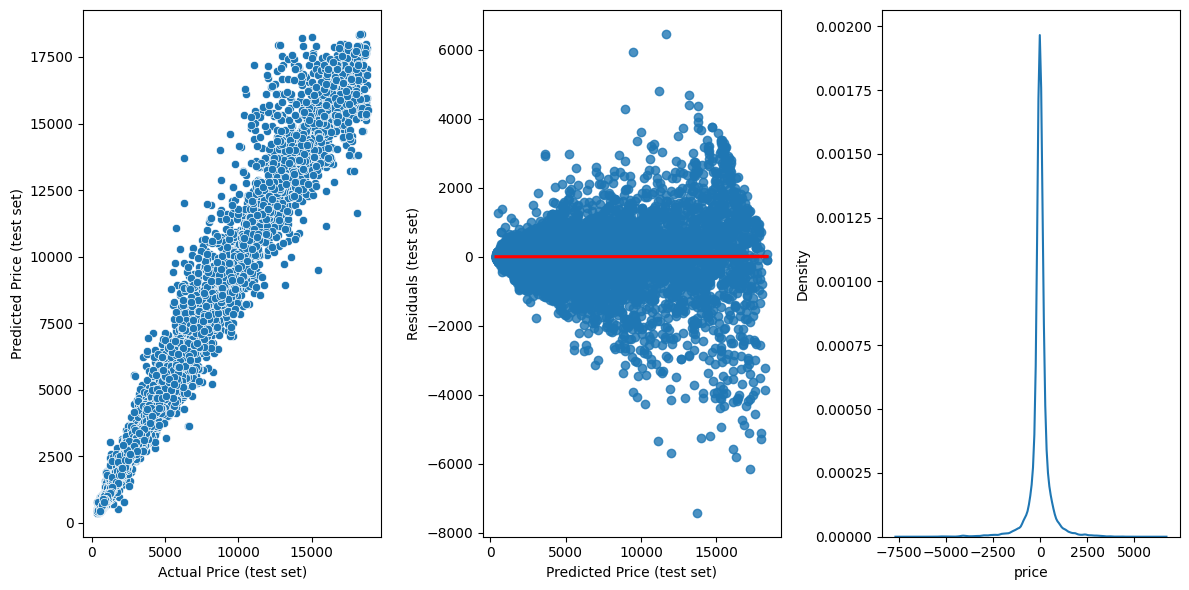

In [240]:
fig, axes = plt.subplots(ncols = 3, nrows = 1, figsize = (12,6))
axes = axes.flatten()
fig.subplots_adjust(wspace = 0.4, hspace = 0.5)

sns.scatterplot(x=y_test, y = rf_mod.predict(X_test), ax=axes[0])
axes[0].set_xlabel("Actual Price (test set)")
axes[0].set_ylabel("Predicted Price (test set)")

sns.regplot(x=rf_mod.predict(X_test), y = res, ax=axes[1],line_kws={"color": "red"})
axes[1].set_xlabel("Predicted Price (test set)")
axes[1].set_ylabel("Residuals (test set)")

sns.kdeplot(x=res, ax=axes[2])


plt.tight_layout()
plt.show()